In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#plot_n_b_psth.ipynb
#plot neural and behavior psth

import scipy.io as sio
import scipy.stats as sio_stat
import scipy.interpolate
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

import os
import pickle
import sys
import copy

import time
import pylab as pl
from IPython import display

from bmi_dynamics_code import behavior_co_obs as bmi_b
from bmi_dynamics_code import data_for_v as preeyacode
from bmi_dynamics_code import util as bmi_util

import timeit
from sklearn import decomposition as skl_decomp

%matplotlib notebook

In [3]:
%matplotlib notebook

In [4]:
# data_dir = '/Users/vivekathalye/Dropbox/Code/preeya_co_obstacle'
save_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\lqr'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
ext_list =['.png', '.eps']

home_dir = r'D:\Dropbox\Code\preeya_co_obstacle'
data_dir = r'D:\Dropbox\Data\preeya_co_obstacle'
data_path = os.path.join(data_dir, 'for_v_df.pkl')
print(os.path.exists(data_path))
d = pickle.load(open(data_path))

#UNPACK: 
decoder = d['decoder']
pre = d['pre']
num_targets = d['num_targets']
sample_period = d['sample_period']
target_hold_time = d['target_hold_time']
num_neurons = d['num_neurons']
target_color = d['target_color']
obs_big = d['obs_big']
obs_small = d['obs_small']
target_r_task = d['target_r_task'] #target_r_task = {0:1.7, 1:2.0}
cursor_r = d['cursor_r']
target_r_eff = d['target_r_eff']
target_pos = d['target_pos']
target_angle = np.arctan2(target_pos[:,1], target_pos[:,0])
target_dist = np.linalg.norm(target_pos, axis=1)
obs_pos = d['obs_pos']

tc_meta = d['tc_meta']
task_list = d['task_list']
num_tasks = len(task_list)
task2idx = d['task2idx']
idx2task = bmi_util.invert_dic(task2idx)
task2tc = d['task2tc']
tc_list = d['tc_list']
df = d['df']
df_label = d['df_label']

task_color = ['k', 'r']

#Pre-processing: 

bmi_b.preprocess_bmi_df(df, target_pos, pre, num_tasks, num_targets)
num_cw = 2
cw_label = ['cw', 'ccw']
task_rot_list = [0,1.1,1.2]

#Binning: 
#MAGNITUDE:
num_mag_bins = 5
num_mag_bins_analyze = 4
# mag_bin_perc = np.array([0,25,50,75,100])
mag_bin_perc = np.concatenate([np.linspace(0,95,5),np.array([100])])
#ANGLE:
num_angle_bins = 8
T0_angle = -3*(2*np.pi)/8
mag_bin, mag_bin_edges, mag_bin_c, angle_bin_c, angle_bin, angle_bin_edges =\
bmi_b.def_command_bin(df, mag_bin_perc, num_angle_bins, T0_angle)
#CENTER ANGLE DATA FOR BINNING (based on bin boundaries): 
angle_center_for_binning = bmi_b.df_center_angle_for_binning(df, angle_bin)
#BIN: 
bmi_b.df_bin_command(df, mag_bin_edges,angle_bin_edges)

#Pre-processing continued:

#Center angles to command bin, target: 
bmi_b.center_df_angle(df, angle_bin_c, target_angle)

True
('angle_center:', 22.5)
('min centered angle:', -157.47162455426732)
('max centered angle:', 202.46708261619673)


<IPython.core.display.Javascript object>


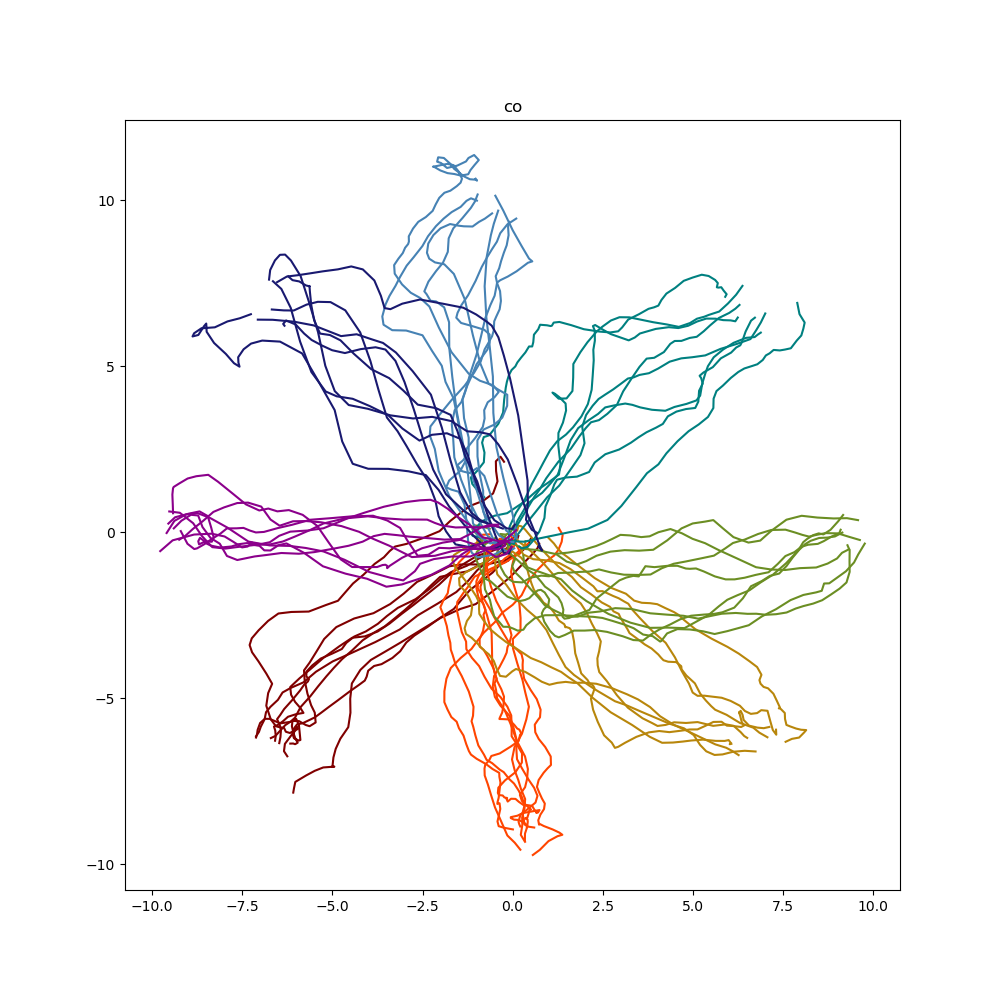

<IPython.core.display.Javascript object>


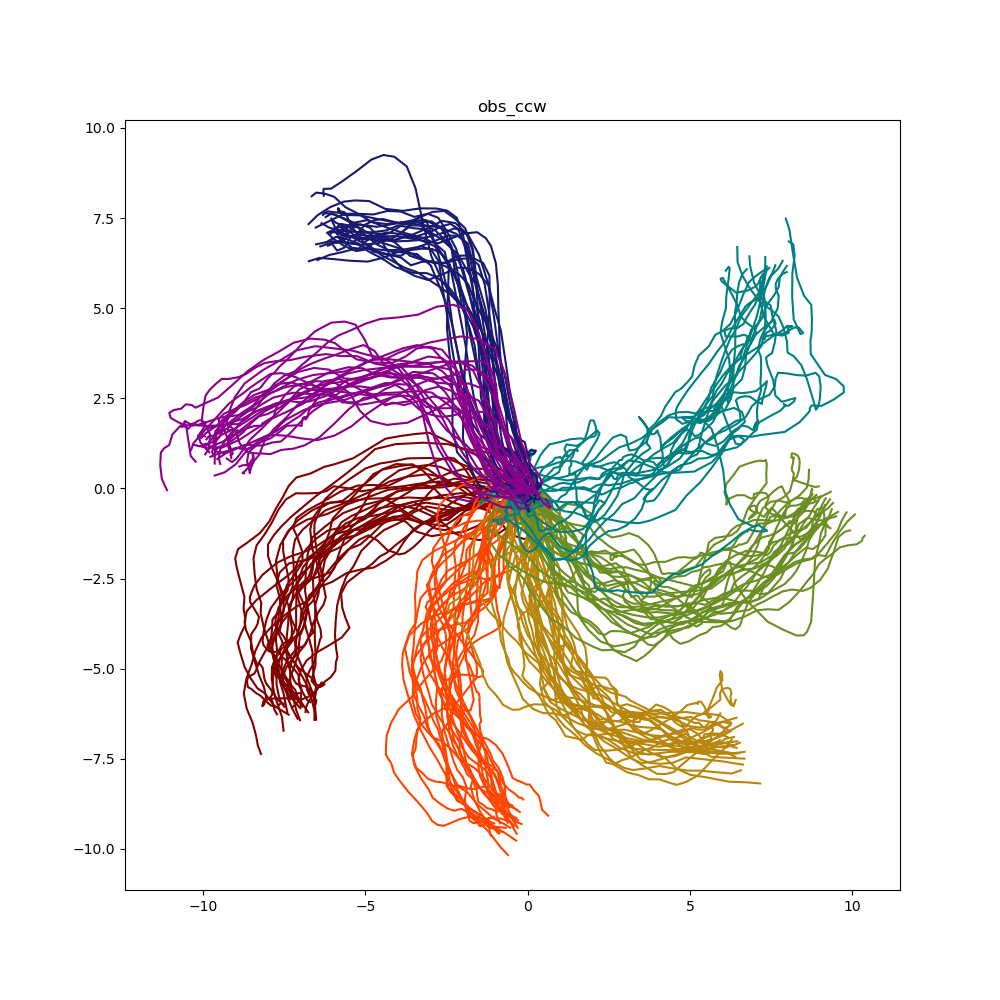

<IPython.core.display.Javascript object>


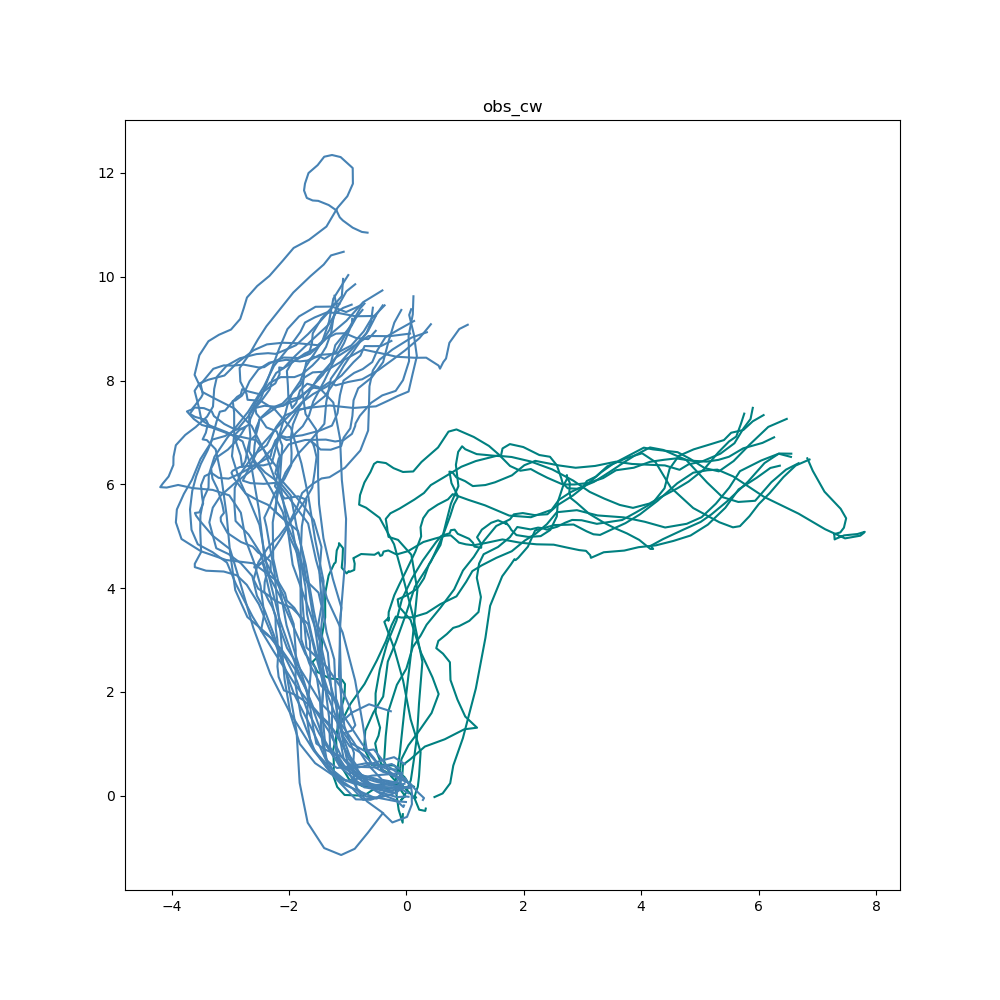

In [5]:
#Plot cw vs ccw trials, to confirm: 
plot = {}
plot['size'] = (10,10)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)
task_rot_list = [0,1.1,1.2]
task_rot_label = ['co','obs_ccw', 'obs_cw']

for i,task in enumerate(task_rot_list):
    plt.figure(figsize=plot['size'])
    plt.title(task_rot_label[i])
    for target in range(num_targets):    
            sel = (df['task_rot']==task) & (df['bin']>=0) & (df['target']==target)
            df_sel = df[sel]
            #------------------------------------------------------------------------------------
            #TRIALS: 
            trial_start = np.where(df_sel['bin']==0)[0]
            trial_stop = np.where(df_sel['bin_end']==0)[0]
            trial_bound = np.vstack((trial_start,trial_stop)).T
            #------------------------------------------------------------------------------------
            for bnd in trial_bound[:,:]: #trial_bound[0:1,:]:
    #             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
                x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
                y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
                color = target_color[target]
                plt.plot(x,y,'-',color=color)

In [38]:
#FORM: xarray for variable x time x trial: 
num_var = df.shape[1]
# time_win = np.array([0, 80])
time_win = np.array([0, 150])
num_time = np.diff(time_win)[0]
da_dic = {}

for i,task in enumerate(task_rot_list):    
    for target in range(num_targets):
        sel = (df['task_rot']==task) & (df['bin']>=0) & (df['target']==target)
        df_sel = df[sel]
        #------------------------------------------------------------------------------------
        #TRIALS: 
        trial_start = np.where(df_sel['bin']==0)[0]
        trial_stop = np.where(df_sel['bin_end']==0)[0]
        trial_bound = np.vstack((trial_start,trial_stop)).T
        num_trials = trial_bound.shape[0]
        #------------------------------------------------------------------------------------
        #Initialize a nan-filled xarray
        nan_mat = np.ones((num_var, num_time, num_trials))*np.nan
        da = xr.DataArray(nan_mat,
                    coords={'var':list(df.columns),
                                     'time':range(num_time),
                                     'trial':range(num_trials)},
                    dims=['var','time','trial'])
        for trial, bnd in enumerate(trial_bound): #trial_bound[0:1,:]:
            trial_len = bnd[1]-bnd[0]
            if trial_len <= num_time:
                bnd[1] = bnd[0] + trial_len
            else:
                bnd[1] = bnd[0] + num_time
            trial_len_trunc = bnd[1]-bnd[0]

            da[:,:trial_len_trunc,trial] = df_sel[bnd[0]:bnd[1]].T
        da_dic[(task,target)] = da      

<IPython.core.display.Javascript object>


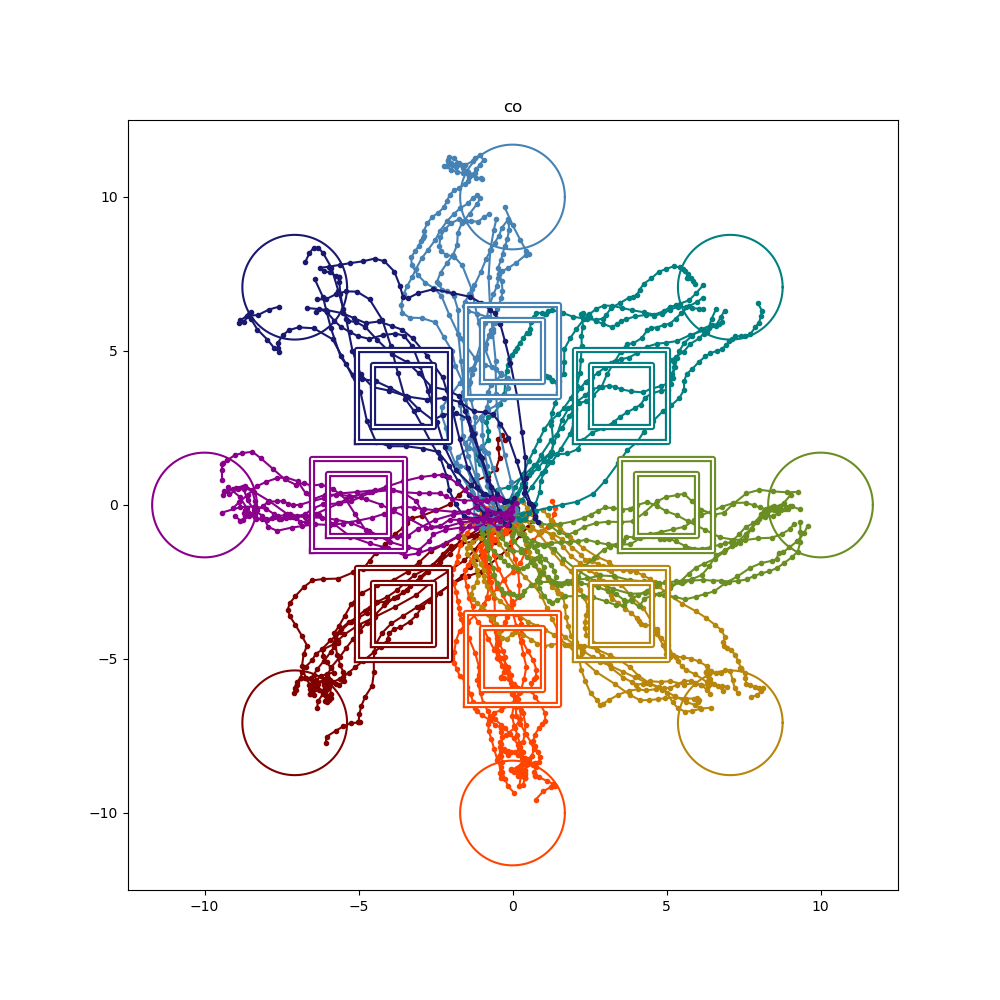

<IPython.core.display.Javascript object>


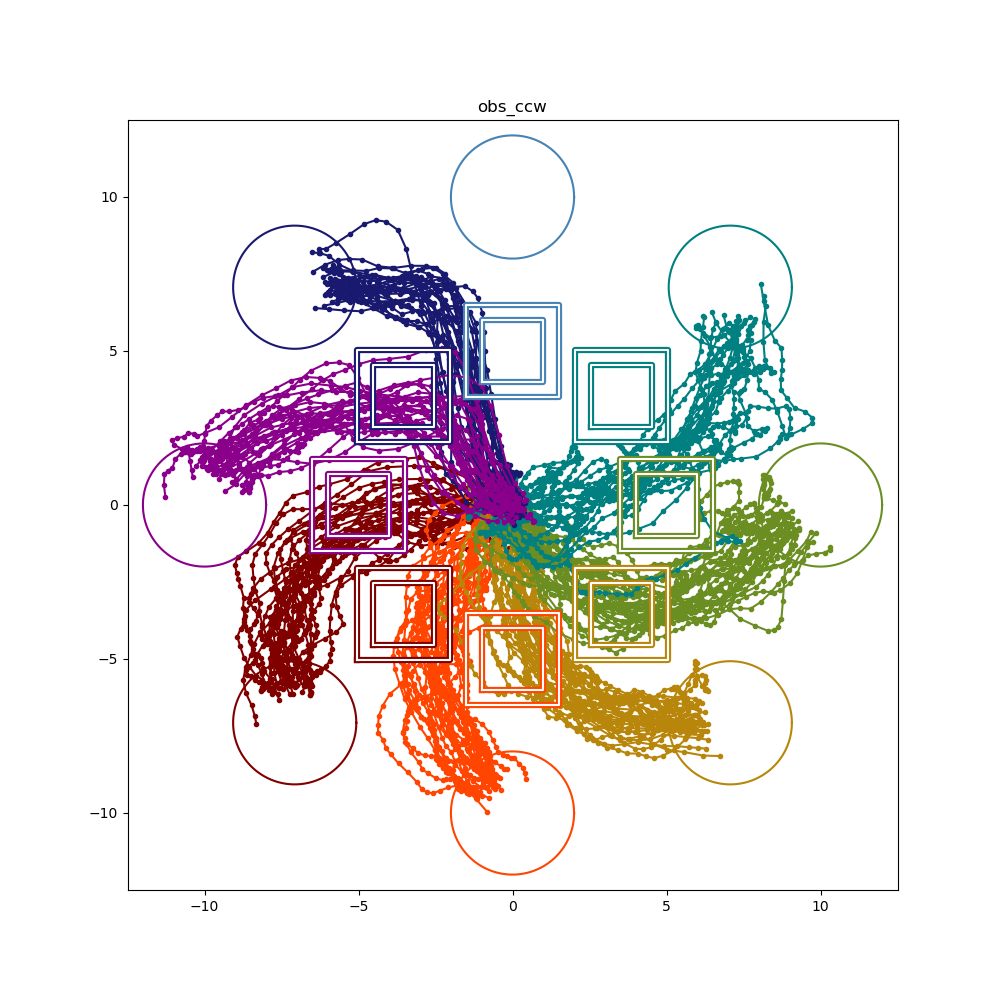

<IPython.core.display.Javascript object>


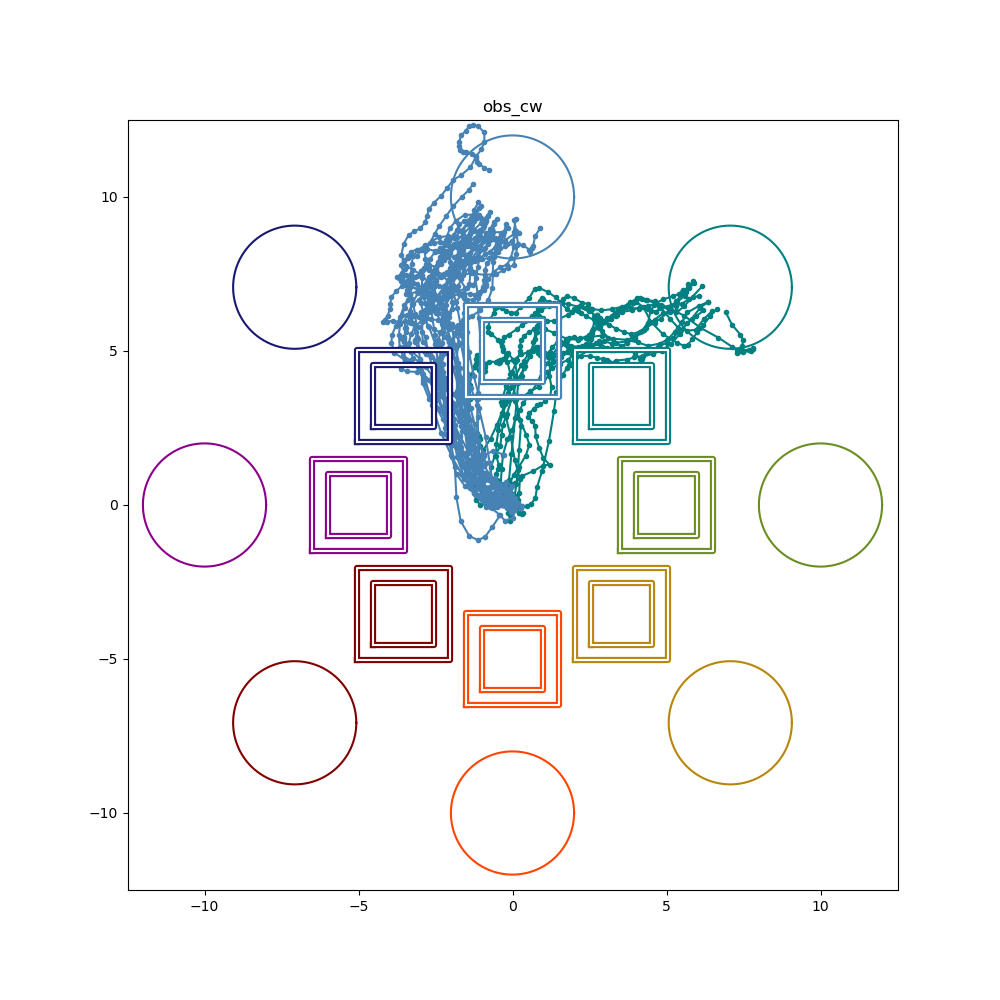

In [39]:
#PLOT ALL DATA in da_dic

plt_prefix = 'trials_p_traj'
plt_ext = ['.png']
save_bool = False

plot_obs_small = True
plot_obs_big = True
plot_target = True

# for task_str in task_list:
for i,task in enumerate(task_rot_list):    
    plt.figure(figsize=plot['size'])
    for target in range(num_targets):
        da = da_dic[task,target]
        x = da.loc['kin_px',:,:] #num_time X num_trials
        y = da.loc['kin_py',:,:]
        color = target_color[target]
        plt.plot(x, y, '.-', color=color)
    if plot_obs_small:
        bmi_util.plot_obstacles(obs_pos, target_color, obs_small*np.ones(num_targets))
    if plot_obs_big:
        bmi_util.plot_obstacles(obs_pos, target_color, obs_big*np.ones(num_targets))
    if plot_target: 
        bmi_util.plot_targets(target_pos, target_color, target_r_task[task>0]*np.ones(num_targets))  
     
    plt.axis('square')
    plt.title(task_rot_label[i])
    plt.xlim(plot['xlim'])
    plt.ylim(plot['ylim'])
    plt.show()
    
    plt_name = plt_prefix + '_' + str(task)
    if save_bool: 
        for ext in plt_ext:
            plt.savefig(os.path.join(save_dir, plt_name+ext))       

In [23]:
task = 0
target = 0
da = da_dic[task,target]
p = da.loc[['kin_px', 'kin_py'],:,:]


In [24]:
p

<xarray.DataArray (var: 2, time: 80, trial: 8)>
array([[[-0.239408, -0.074868, ...,  0.044822,  0.735074],
        [-0.336949, -0.113363, ..., -0.065133,  0.687186],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       [[ 2.121039, -0.698545, ..., -0.139227, -0.345067],
        [ 2.272008, -0.852063, ..., -0.267276, -0.486551],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]]])
Coordinates:
  * var      (var) |S23 'kin_px' 'kin_py'
  * trial    (trial) int32 0 1 2 3 4 5 6 7
  * time     (time) int32 0 1 2 3 4 5 6 7 8 9 ... 70 71 72 73 74 75 76 77 78 79

In [29]:
p_psth = p.mean(axis=2,skipna=False)

In [30]:
p_psth

<xarray.DataArray (var: 2, time: 80)>
array([[ 0.010148, -0.114788, -0.341322, -0.620077, -0.931886, -1.297352,
        -1.639691, -1.995962, -2.371997, -2.78714 , -3.177914, -3.564052,
        -3.898574, -4.220483, -4.519827, -4.774554, -5.005639, -5.181414,
        -5.319847, -5.456767, -5.554333, -5.470213, -5.580751, -5.715144,
        -5.907853, -6.115162, -6.295345, -6.435045, -6.54287 , -6.565475,
        -6.575051, -6.449825, -6.302201, -6.33472 , -6.36653 , -6.318852,
        -6.284288, -6.276651, -6.231571, -6.183605, -6.102858, -6.022506,
        -6.03639 , -6.035165, -5.954273, -6.016885, -6.146314, -6.317017,
        -6.34324 ,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,


<IPython.core.display.Javascript object>


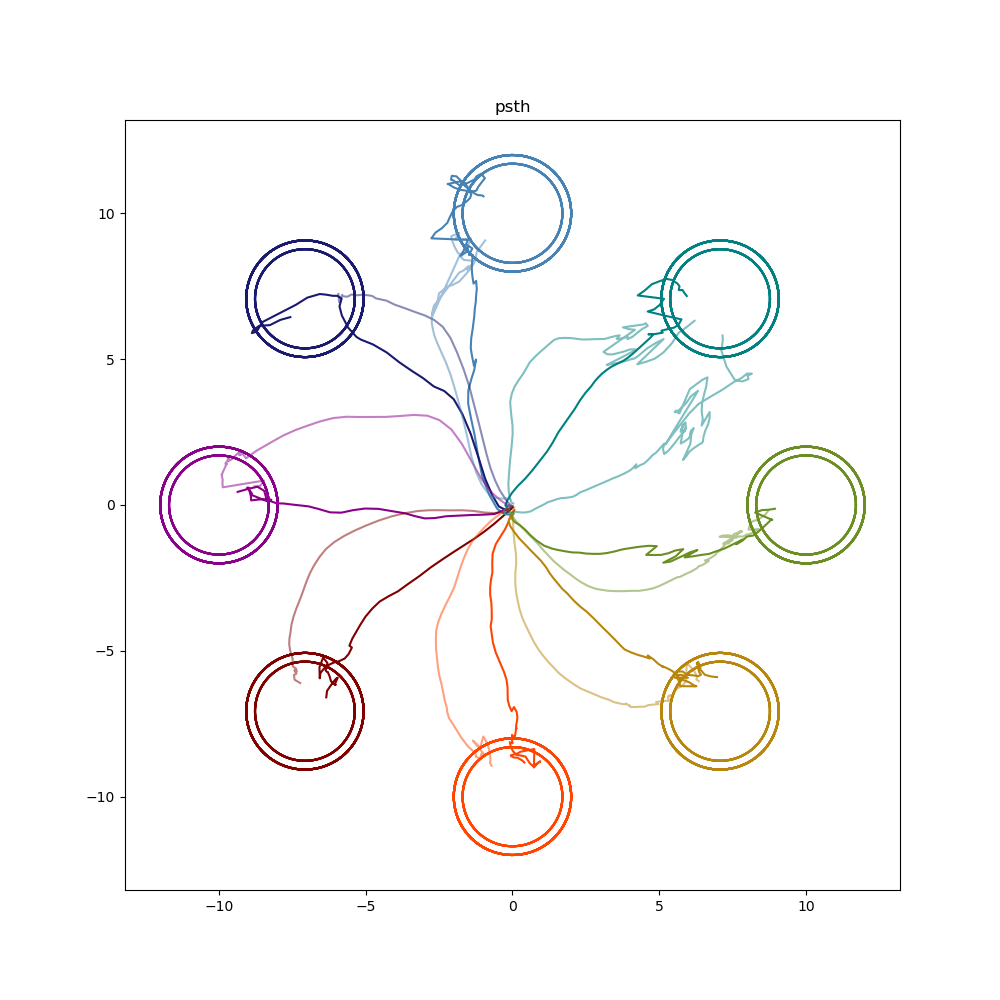

Text(0.5,1,'psth')

In [134]:
#Calculate the PSTH: 
task_alpha = [1, 0.5]
plt.figure(figsize=plot['size'])
for i,task in enumerate(task_rot_list):
    for target in range(num_targets):
        da = da_dic[task,target]
        da_dic[task,target,'psth'] = da.mean(axis=2, skipna=True)
        
        p_psth = da_dic[task,target,'psth']
        
        x = p_psth.loc['kin_px',:] #num_time X num_trials
        y = p_psth.loc['kin_py',:]
        color = target_color[target]
        
        plt.plot(x, y, '-', color=color, alpha=task_alpha[task>0])
#         if plot_obs_small:
#             bmi_util.plot_obstacles(obs_pos, target_color, obs_small*np.ones(num_targets))
#         if plot_obs_big:
#             bmi_util.plot_obstacles(obs_pos, target_color, obs_big*np.ones(num_targets))
        if plot_target: 
            bmi_util.plot_targets(target_pos, target_color, target_r_task[task>0]*np.ones(num_targets)) 
plt.title('psth')
        

<IPython.core.display.Javascript object>


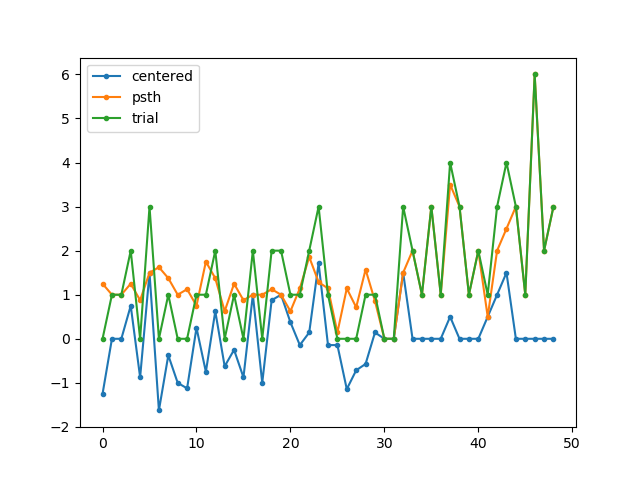

In [67]:
# #Inspect the subtraction of the psth: 
# # test = da_dic[0,0].loc[n_list,:,:]-da_dic[0,0,'psth'].loc[n_list,:,...]
# test = da_dic[0,0,'centered']
# trial=0
# n = 'n_0'

# centered = test.loc[n,:,trial]
# c = da_dic[0,0,'psth'].loc[n,:]
# d = da_dic[0,0].loc[n,:,trial]
# plt.figure()
# plt.plot(centered, '.-', label='centered')
# plt.plot(c, '.-', label='psth')
# plt.plot(d, '.-', label='trial')
# plt.legend()


In [120]:
#Pool PSTH's and data matrices
total_pool = []
psth_pool = []
res_pool = []
for i,task in enumerate(task_rot_list):
    for target in range(num_targets):
        total_pool.append(da_dic[task,target])
        res_pool.append(da_dic[task,target,'residual'])
        psth_pool.append(da_dic[task,target,'psth'])

total_pool = xr.concat(total_pool, dim='trial')
psth_pool = xr.concat(psth_pool, dim='time')
res_pool = xr.concat(res_pool, dim='trial')

# #inspect by plotting position: 
# kin_psth_ma = np.ma.array(psth_pool.loc[['kin_px', 'kin_py'],:], mask=np.isnan(psth_pool.loc[['kin_px', 'kin_py'],:]))
# plt.figure()
# plt.plot(kin_psth_ma[0,:], kin_psth_ma[1,:])

<IPython.core.display.Javascript object>


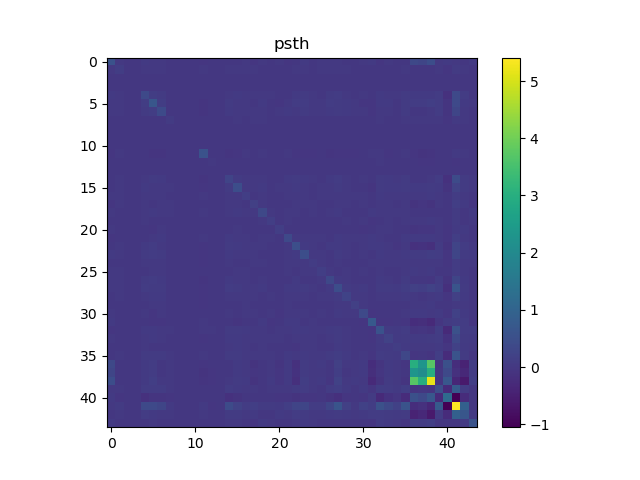

<IPython.core.display.Javascript object>


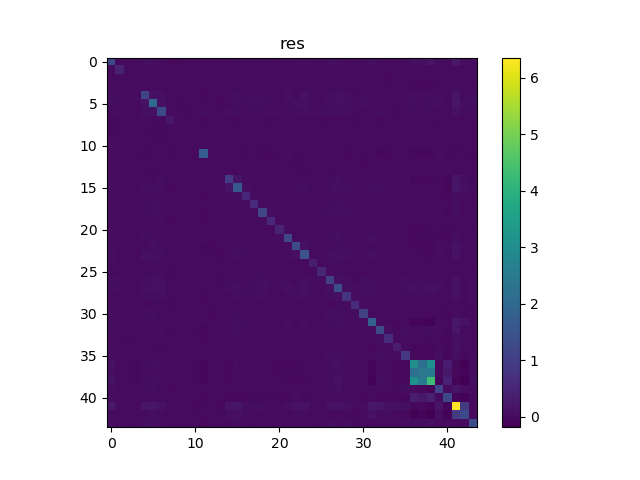

<IPython.core.display.Javascript object>


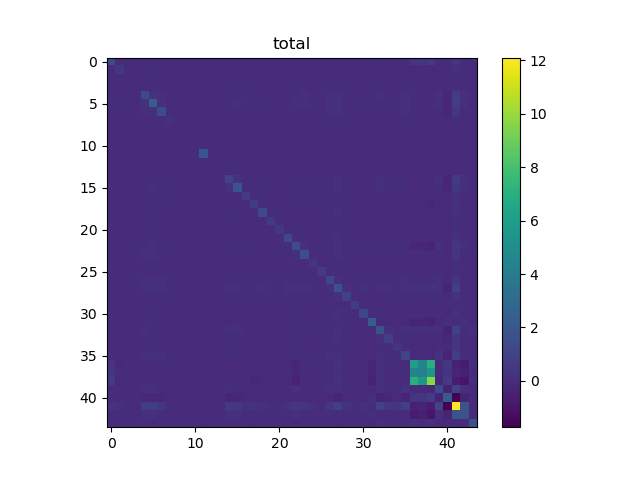

<IPython.core.display.Javascript object>


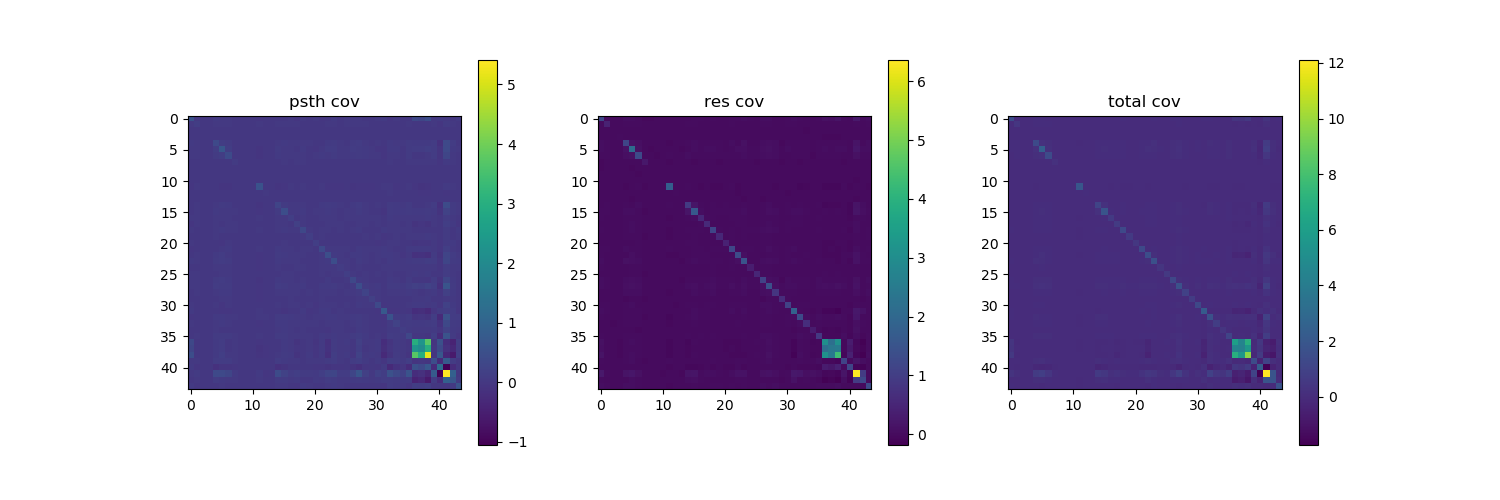

In [126]:
#COVARIANCE: PSTH, RESIDUAL, TOTAL 

#PSTH COVARIANCE: 
psth_ma = np.ma.array(psth_pool.loc[n_list,:], mask=np.isnan(psth_pool.loc[n_list,:]))
psth_cov = np.ma.cov(psth_ma)#, allow_masked=False)

#plt
plt.figure()
plt.imshow(psth_cov)
plt.colorbar()
plt.title('psth')


#RESIDUAL COVARIANCE
res_ma = np.ma.array(res_pool.loc[n_list,:,:], mask=np.isnan(res_pool.loc[n_list,:,:]))
# test = res_ma.reshape((num_neurons,-1))
# test.shape
res_cov = np.ma.cov(res_ma.reshape((num_neurons,-1)))

#plt
plt.figure()
plt.imshow(res_cov)
plt.colorbar()
plt.title('res')


#TOTAL COVARIANCE
total_ma = np.ma.array(total_pool.loc[n_list,:,:], mask=np.isnan(total_pool.loc[n_list,:,:]))
total_cov = np.ma.cov(total_ma.reshape((num_neurons,-1)))

#plt
plt.figure()
plt.imshow(total_cov)
plt.colorbar()
plt.title('total')

#Plot them side by side
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(psth_cov)
plt.title('psth cov')
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(res_cov)
plt.title('res cov')
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(total_cov)
plt.title('total cov')
plt.colorbar()

<IPython.core.display.Javascript object>


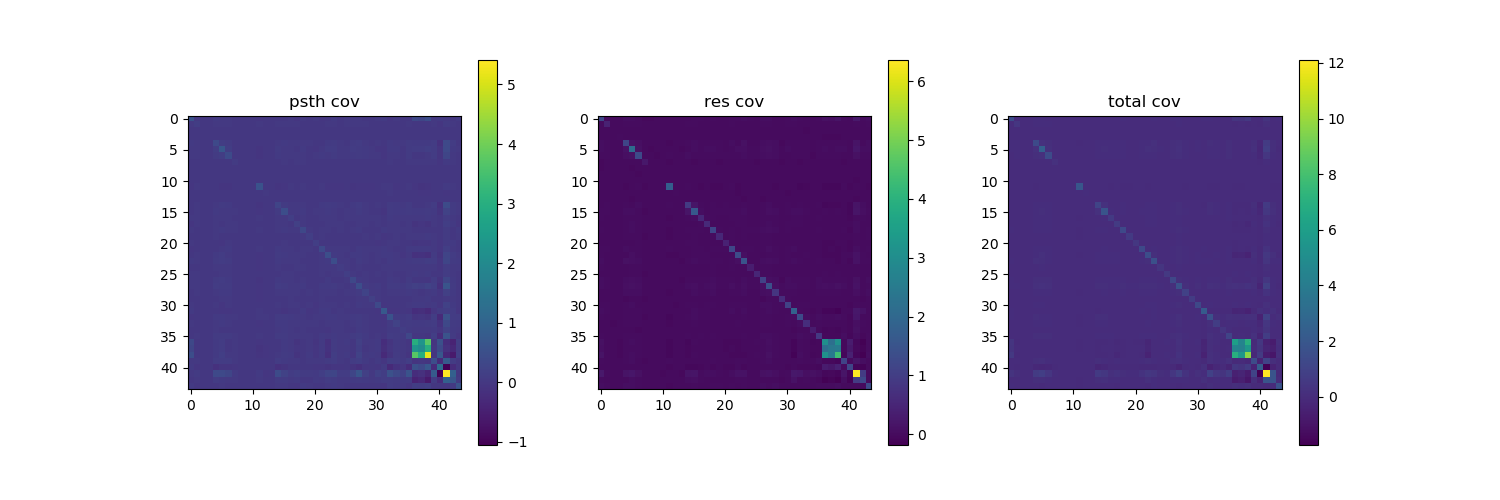

<IPython.core.display.Javascript object>


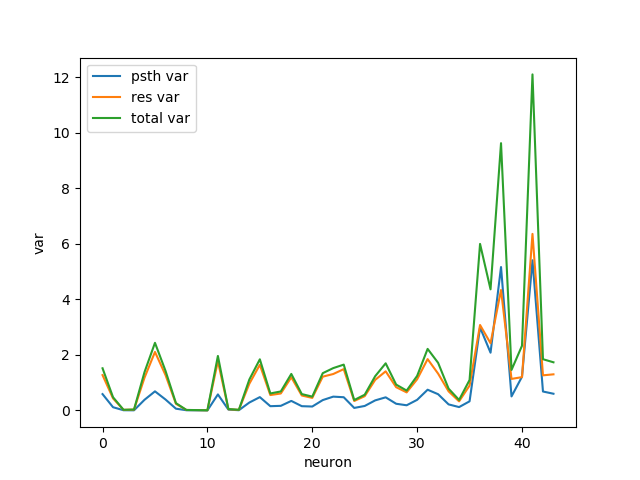

<IPython.core.display.Javascript object>


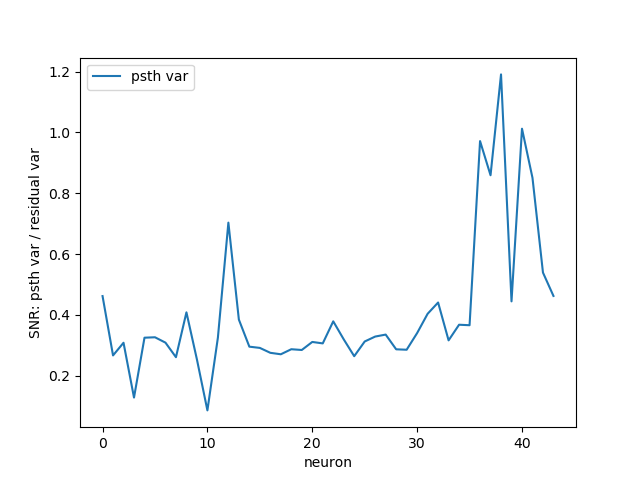

0.38865904743081114


In [132]:
psth_var = np.diag(psth_cov)
res_var = np.diag(res_cov)
total_var = np.diag(total_cov)

plt.figure()
plt.plot(psth_var, label='psth var')
plt.plot(res_var, label='res var')
plt.plot(total_var, label='total var')
plt.xlabel('neuron')
plt.ylabel('var')
plt.legend()

plt.figure()
plt.plot(psth_var/res_var, label='psth var')
plt.xlabel('neuron')
plt.ylabel('SNR: psth var / residual var')
plt.legend()

print(sum(psth_var)/sum(total_var))

In [140]:
#SAVE RESULTS: 
r = {}
r['da_dic'] = da_dic
r['task_rot_list'] = task_rot_list
r['num_targets'] = num_targets
r['psth_ma'] = psth_ma
r['psth_cov'] = psth_cov
r['psth_var'] = psth_var
r['res_ma'] = res_ma
r['res_cov'] = res_cov
r['res_var'] = res_var
r['total_ma'] = total_ma
r['total_cov'] = total_cov
r['total_var'] = total_var
snr = psth_var/res_var
r['snr'] = snr

### Save psth data: 
save_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\psth'
save_path = os.path.join(save_dir, 'psth.pkl')
with open(save_path, 'wb') as f: 
    data = pickle.dump(r, f, protocol=pickle.HIGHEST_PROTOCOL)
